In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

## Land Cover Classification: Sentinel-2 with EuroCrops

_Written by: Burak Ekim_

This tutorial will walk you through the process of performing land cover classification with Sentinel-2 satellite imagery, annotated with EuroCrops, using TorchGeo. We will start with downloading Sentinel-2 data, setting it up with EuroCrops for pixel-wise supervised classification, training a segmentation model, and finally running inference to make sense of Sentinel-2 imagery. 

Whether you are a remote sensing enthusiast or just curious about deep learning for geospatial data, this guide has something cool for you!

### 0- Required Imports

In [2]:
import os
from urllib.parse import urlparse

import matplotlib.pyplot as plt
import planetary_computer
import pystac
import torch
from torch.utils.data import DataLoader
from torchgeo.datasets.utils import download_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)

### 1- Downloading Sentinel-2 Imagery

Fetch Sentinel-2 imagery using Microsoft Planetary Computer and ensure you have the data you need. Note that the Sentinel-2 imagers should match the label source both _spatially_ and _temporally_ and EuroCrops is comprised of vector-form annotations of EU countries sourced from different years. 

In [3]:
root = r"C:\Users\burak\Desktop\tdata"
item_urls = [
    'https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2B_MSIL2A_20210810T095029_R079_T33UXP_20210810T215311',
]
for item_url in item_urls:
    item = pystac.Item.from_file(item_url)
    signed_item = planetary_computer.sign(item)
    for band in ['B02', 'B03', 'B04', 'B08']:
        asset_href = signed_item.assets[band].href
        filename = urlparse(asset_href).path.split('/')[-1]
        download_url(asset_href, root, filename)

Using downloaded and verified file: C:\Users\burak\Desktop\tdata\T33UXP_20210810T095029_B02_10m.tif
Using downloaded and verified file: C:\Users\burak\Desktop\tdata\T33UXP_20210810T095029_B03_10m.tif
Using downloaded and verified file: C:\Users\burak\Desktop\tdata\T33UXP_20210810T095029_B04_10m.tif
Using downloaded and verified file: C:\Users\burak\Desktop\tdata\T33UXP_20210810T095029_B08_10m.tif


### 2-  Prepare Dataloader

Customize TorchGeo to align `Sentinel2` and `EuroCrops` datasets, forming an `IntersectionDataset` for pixel-wise classification task

TODO: 
- Introduce the dataset: many countries with varying classes, annotation volume, curation time
- Curation time makes the choice of accompanying S2 important: the temporal dimension should overlap

In [4]:
from torchgeo.datasets import EuroCrops

class EuroCropSK(EuroCrops):
    base_url = 'https://zenodo.org/records/8229128/files/'

    hcat_fname = 'HCAT2.csv'
    hcat_md5 = 'b323e8de3d8d507bd0550968925b6906'
    # Name of the column containing HCAT code in CSV file.
    hcat_code_column = 'HCAT2_code'

    label_name = 'EC_hcat_c'

    filename_glob = '*_EC*.shp'

    # Override variables to automatically extract timestamp.
    filename_regex = r"""
        ^(?P<country>[A-Z]{2})
        (_(?P<region>[A-Z]+))?
        _
        (?P<date>\d{4})
        _
        (?P<suffix>EC(?:21)?)
        \.shp$
    """
    date_format = '%Y'
    zenodo_files: tuple[tuple[str, str], ...] = (
        ('SK_2021.zip', 'c7762b4073869673edc08502e7b22f01'),
    )

In [5]:
from torchgeo.datasets import RasterDataset

class Sentinel2Custom(RasterDataset):
    filename_glob = 'T3*_B0*_10m.tif'
    filename_regex = r'^.{6}_(?P<date>\d{8}T\d{6})_(?P<band>B0[\d])'
    date_format = '%Y%m%dT%H%M%S'
    is_image = True
    separate_files = True
    all_bands = ('B02', 'B03', 'B04', 'B08')
    rgb_bands = ('B04', 'B03', 'B02')
    
    def plot(self, sample):
        rgb_indices = []
        for band in self.rgb_bands:
            rgb_indices.append(self.all_bands.index(band))

        image = sample['image'][rgb_indices].permute(1, 2, 0)
        image = torch.clamp(image / 10000, min=0, max=1).numpy()

        fig, ax = plt.subplots()
        ax.imshow(image)

        return fig
        
import torchgeo.datasets
torchgeo.datasets.Sentinel2 = Sentinel2Custom
torchgeo.datasets.EuroCrops = EuroCropSK

- TODO: How do we set .bounds? Maybe limit to that small AOI early on so that training is also done on a small area? Might be good for PoC, then move to the WS for GPU stuff

In [ ]:
Sentinel2Customa

In [37]:
Sentinel2EuroCropsDataModule?

Init signature:
Sentinel2EuroCropsDataModule(
    batch_size: int = 64,
    patch_size: int | tuple[int, int] = 256,
    length: int | None = None,
    num_workers: int = 0,
    **kwargs: Any,
) -> None
Docstring:     
LightningDataModule implementation for the EuroCrops and Sentinel2 datasets.

Uses the train/val/test splits from the dataset.

.. versionadded:: 0.6
Init docstring:
Initialize a new Sentinel2EuroCropsDataModule instance.

Args:
    batch_size: Size of each mini-batch.
    patch_size: Size of each patch, either ``size`` or ``(height, width)``.
    length: Length of each training epoch.
    num_workers: Number of workers for parallel data loading.
    **kwargs: Additional keyword arguments passed to
        :class:`~torchgeo.datasets.EuroCrops` (prefix keys with ``eurocrops_``)
        and :class:`~torchgeo.datasets.Sentinel2`
        (prefix keys with ``sentinel2_``).
File:           c:\users\burak\desktop\torchgeo\torchgeo\datamodules\sentinel2_eurocrops.py
Type:       

In [39]:
dir(Sentinel2EuroCropsDataModule)

['CHECKPOINT_HYPER_PARAMS_KEY',
 'CHECKPOINT_HYPER_PARAMS_NAME',
 'CHECKPOINT_HYPER_PARAMS_TYPE',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__jit_unused_properties__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_dataloader_factory',
 '_set_hparams',
 '_to_hparams_dict',
 '_valid_attribute',
 'from_datasets',
 'hparams',
 'hparams_initial',
 'load_from_checkpoint',
 'load_state_dict',
 'mean',
 'name',
 'on_after_batch_transfer',
 'on_before_batch_transfer',
 'on_exception',
 'plot',
 'predict_dataloader',
 'prepare_data',
 'save_hyperparameters',
 'setup',
 'state_dict',
 'std',
 'teardown',
 'test_dataloader',
 'train_dataloader',
 'transfer_batch_to_device',
 'val_dataloader']

In [19]:
from torchgeo.datamodules import Sentinel2EuroCropsDataModule

datamodule = Sentinel2EuroCropsDataModule(
    sentinel2_paths=r"C:\Users\burak\Desktop\tdata",
    eurocrops_paths=r"C:\Users\burak\Desktop\tdata",
    batch_size=2,
    patch_size=256,
    num_workers=os.cpu_count(),
    eurocrops_download=True,
    persistent_workers=True
)

datamodule.setup("fit")
train_dataset = datamodule.train_dataset
datamodule.setup("validate")
val_dataset = datamodule.val_dataset
datamodule.setup("test")
test_dataset = datamodule.test_dataset

Files already downloaded and verified
Converting EuroCropSK CRS from EPSG:4326 to EPSG:32633
Converting EuroCropSK res from 1e-05 to 10.0
Files already downloaded and verified
Converting EuroCropSK CRS from EPSG:4326 to EPSG:32633
Converting EuroCropSK res from 1e-05 to 10.0
Files already downloaded and verified
Converting EuroCropSK CRS from EPSG:4326 to EPSG:32633
Converting EuroCropSK res from 1e-05 to 10.0


In [20]:
datamodule.sentinel2.files, datamodule.sentinel2.crs, datamodule.sentinel2.bounds, datamodule.sentinel2.crs, datamodule.eurocrops.files

(['C:\\Users\\burak\\Desktop\\tdata\\T33UXP_20210810T095029_B02_10m.tif',
  'C:\\Users\\burak\\Desktop\\tdata\\T33UXP_20210810T095029_B03_10m.tif',
  'C:\\Users\\burak\\Desktop\\tdata\\T33UXP_20210810T095029_B04_10m.tif',
  'C:\\Users\\burak\\Desktop\\tdata\\T33UXP_20210810T095029_B08_10m.tif'],
 CRS.from_wkt('PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32633"]]'),
 BoundingBox(minx=600000.0, maxx=709800.0, miny=5290200.0, maxy=5400000.0, mint=1628581

Let's see where our Sentinel-2 and annotations are

In [21]:
import folium
from shapely.geometry import box
import geopandas as gpd
from pyproj import Transformer

def visualize_bounding_boxes(sentinel_bounds, eurocrops_bounds, sentinel_crs, eurocrops_crs):
    """
    Visualize bounding boxes on a map using folium.

    Args:
        sentinel_bounds: BoundingBox object for Sentinel-2
        eurocrops_bounds: BoundingBox object for EuroCrops
        sentinel_crs: Coordinate Reference System (CRS) for Sentinel-2
        eurocrops_crs: Coordinate Reference System (CRS) for EuroCrops
    """
    # Unpack bounding boxes
    minx1, maxx1, miny1, maxy1 = sentinel_bounds.minx, sentinel_bounds.maxx, sentinel_bounds.miny, sentinel_bounds.maxy
    minx2, maxx2, miny2, maxy2 = eurocrops_bounds.minx, eurocrops_bounds.maxx, eurocrops_bounds.miny, eurocrops_bounds.maxy

    # Transform to WGS84 (EPSG:4326)
    sentinel_transformer = Transformer.from_crs(sentinel_crs, "EPSG:4326", always_xy=True)
    eurocrops_transformer = Transformer.from_crs(eurocrops_crs, "EPSG:4326", always_xy=True)

    minx1, miny1 = sentinel_transformer.transform(minx1, miny1)
    maxx1, maxy1 = sentinel_transformer.transform(maxx1, maxy1)

    minx2, miny2 = eurocrops_transformer.transform(minx2, miny2)
    maxx2, maxy2 = eurocrops_transformer.transform(maxx2, maxy2)

    bbox1 = box(minx1, miny1, maxx1, maxy1)
    bbox2 = box(minx2, miny2, maxx2, maxy2)

    gdf1 = gpd.GeoDataFrame({"geometry": [bbox1]}, crs="EPSG:4326")
    gdf2 = gpd.GeoDataFrame({"geometry": [bbox2]}, crs="EPSG:4326")

    center_lat = (miny1 + maxy1 + miny2 + maxy2) / 4
    center_lon = (minx1 + maxx1 + minx2 + maxx2) / 4
    m = folium.Map(location=[center_lat, center_lon], zoom_start=5)

    folium.GeoJson(gdf1, style_function=lambda x: {"color": "blue", "weight": 2}, name="BoundingBox 1").add_to(m)
    folium.GeoJson(gdf2, style_function=lambda x: {"color": "green", "weight": 2}, name="BoundingBox 2").add_to(m)

    folium.LayerControl().add_to(m)

    return m

map_ = visualize_bounding_boxes( datamodule.sentinel2.bounds,  datamodule.eurocrops.bounds,  datamodule.sentinel2.crs,  datamodule.eurocrops.crs)
map_

#### Visualize the Sentinel-2 imagery and EuroCrops Labels

We pick a small AOI from the intersection of our image (Sentinel-2) and mask (EuroCrops).

- The bounding box coordinates has to be in the matched coordinate reference system (CRS) of image and mask i.e., datamodule.sentinel2.bounds
- Temporal bounds (the last to dims of BoundingBox) are not crucial for this usecase, fixing them to masks's temporal bounds

In [22]:
datamodule.sentinel2.crs, datamodule.eurocrops.crs

(CRS.from_wkt('PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32633"]]'),
 CRS.from_wkt('PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["ce

In [23]:
datamodule.sentinel2.res, datamodule.eurocrops.res

(10.0, 10.0)

In [24]:
from torchgeo.datasets import BoundingBox
small_aoi = BoundingBox(664069.4833,669848.1270, 5337846.0840,5342849.2272, datamodule.eurocrops.bounds[-2], datamodule.eurocrops.bounds[-1])

In [25]:
width = small_aoi.maxx - small_aoi.minx
height = small_aoi.maxy - small_aoi.miny
print(f"BoundingBox Width: {width} meters")
print(f"BoundingBox Height: {height} meters")

BoundingBox Width: 5778.643700000015 meters
BoundingBox Height: 5003.143199999817 meters


Does our AOI intersect the image and mask? 

In [26]:
datamodule.sentinel2.bounds.intersects(small_aoi), datamodule.eurocrops.bounds.intersects(small_aoi)

(True, True)

Let's query the image and mask to our AOI

In [27]:
s2_crop = datamodule.sentinel2[small_aoi]
eurocrops_crop = datamodule.eurocrops[small_aoi]

Feature does not contain the label 'EC_hcat_c'. Skip rendering.
Feature does not contain the label 'EC_hcat_c'. Skip rendering.


In [28]:
s2_crop['image'].shape, eurocrops_crop['mask'].shape

(torch.Size([4, 500, 578]), torch.Size([500, 578]))

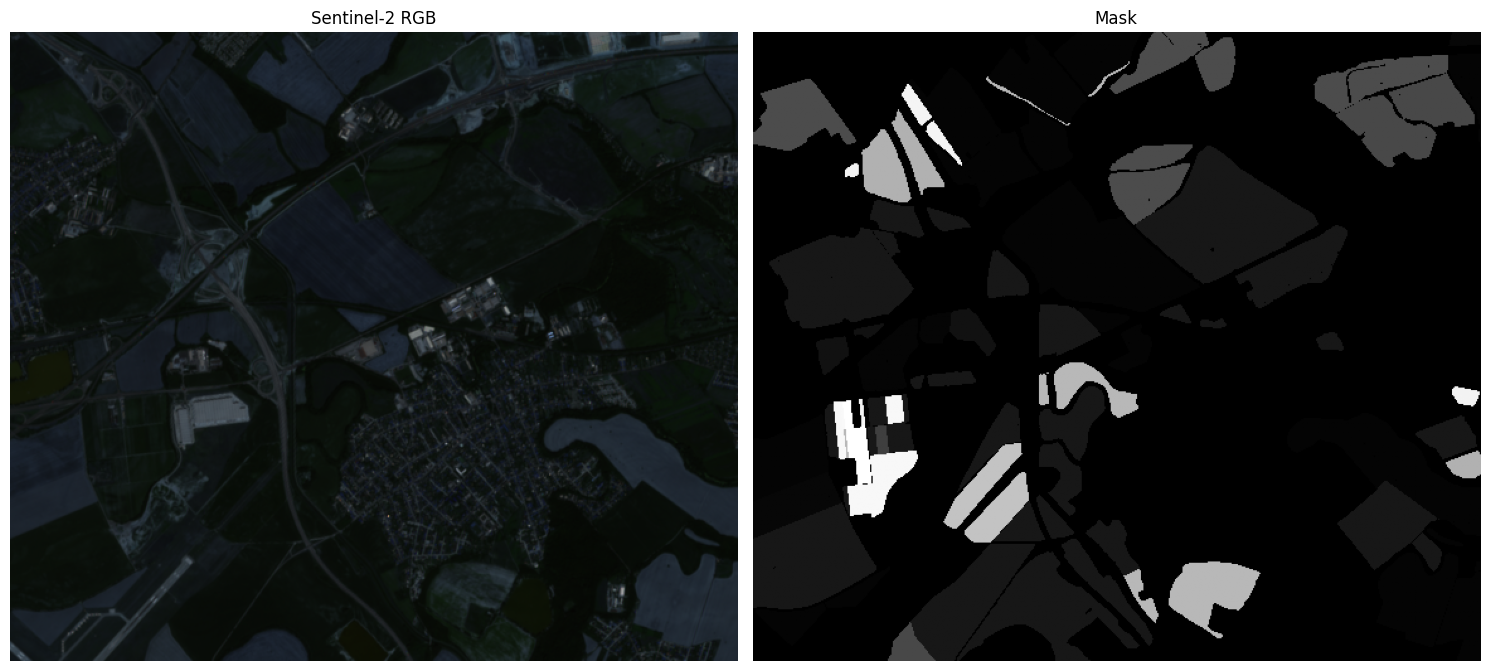

In [34]:
image_tensor = s2_crop['image']
mask_tensor = eurocrops_crop['mask']
image_mask_tuple = (image_tensor, mask_tensor)

# Extract image and mask
image, mask = image_mask_tuple
rgb_image = image[:3, :, :]  # Shape: [3, 500, 578]
rgb_image_np = rgb_image.numpy().transpose(1, 2, 0) / 10000  # Shape: [500, 578, 3]
mask_np = mask.numpy()

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plot the Sentinel-2 image
axes[0].imshow(rgb_image_np)
axes[0].set_title('Sentinel-2 RGB')
axes[0].axis('off')

# Plot the Mask
axes[1].imshow(mask_np, cmap='gray')
axes[1].set_title('Mask')
axes[1].axis('off') 

plt.tight_layout()
plt.show()

### 3- Training Semantic Segmentation Model

Train a UNet model with Sentinel-2 images paired with EuroCrops labels to classify land cover, powered by PyTorch Lightning

TODO:
- Crack the class nuance: The country you are using has N number of classes and the total dataset offers a lot more than N -- there has to be a mapping function to aggregate the original classes into N 

- Currently no GPU support
- No workers

In [ ]:
from torchgeo.trainers import SemanticSegmentationTask
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='C:/Users/burak/Desktop/tdata/checkpoints',
    filename='s2_eurocrops-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min', 
    save_weights_only=True,
    verbose=True
    )

task = SemanticSegmentationTask(
    model='unet',
    backbone='resnet50',
    weights=None,  # TODO: Add pretrained weights
    in_channels=4,
    num_classes=396, # TODO: The country I am working on has less classes? Check the doc and find a mapping
    num_filters=3,
    loss='ce',
    class_weights=None,
    ignore_index=None,
    lr=0.001,
    patience=10,
    freeze_backbone=False,
    freeze_decoder=False)

trainer = Trainer(
    accelerator='cpu',
    default_root_dir=r'C:\Users\burak\Desktop\tdata',
    fast_dev_run=False,
    log_every_n_steps=10,
    min_epochs=2,
    max_epochs=20,
    num_sanity_val_steps=0,
    callbacks=[checkpoint_callback]
    )

trainer.fit(model=task, datamodule=datamodule)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | Unet             | 32.5 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total params
130.098   Total estimated model params size (MB)
233       Modules in train mode
0         Modules 

Files already downloaded and verified
Files already downloaded and verified
Converting EuroCropSK CRS from EPSG:4326 to EPSG:32633
Converting EuroCropSK res from 1e-05 to 10.0


c:\Users\burak\anaconda3\envs\torchgeo_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Epoch 0:   0%|          | 0/2460 [00:00<?, ?it/s] 

RuntimeError: DataLoader worker (pid(s) 37272, 21876, 20300, 29576) exited unexpectedly

### 4- Model Evaluation on Test Set

Evaluate the segmentation model over the test set

### 5- Inference over full Imagery

Perform inference by computing predictions over the complete imagery 